# Tutorial 8: Exploratory Data Analysis

## Background

As a data scientist at Heilbronn Hospital, you've been tasked with conducting a thorough exploratory data analysis (EDA) of patient records. The medical team needs to understand patterns in patient care, identify data quality issues, and gain insights that could lead to improved treatment protocols. Your analysis will help the hospital make data-driven decisions about resource allocation and patient care strategies.

1. Data Quality Assessment: The ICU's electronic health records system occasionally has gaps in data collection due to emergency situations or equipment issues. Import the dataset 'icu_data_example.csv' into a DataFrame, then identify which vital signs and patient information are most frequently missing by calculating the percentage of missing values in each column. This analysis will help the hospital improve their data collection protocols.

In [1]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')

missing_percentages = df.isnull().mean() * 100

missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

print(missing_percentages_sorted)

HCO3 (serum)            35.866667
PH (Arterial)           28.100000
Magnesium               17.700000
stay_id                  0.000000
los                      0.000000
age                      0.000000
Heart Rate               0.000000
weight                   0.000000
gender                   0.000000
Arterial O2 pressure     0.000000
dtype: float64


2. Data Imputation Strategy: For accurate patient assessment, we need to handle missing data carefully. Implement a for-loop to iterate over all vital sign measurements and replace missing values with the median of the respective column, but only where the missing data is below 20%. This conservative approach ensures we only fill in gaps where we have sufficient reliable data to make educated estimates.


In [2]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')
vital_sign_cols = df.select_dtypes(include=['float64', 'int64']).columns

#prettifying the output
GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

for col in vital_sign_cols:
    missing_pct = df[col].isnull().mean() * 100
    if missing_pct < 20:
        median_value = df[col].median()
        df.fillna({col: median_value}, inplace=True)
        print(f"{GREEN}Filled missing values in '{col}' with median ({median_value}) - missing percentage {missing_pct:.2f}%{RESET}")
    else:
        print(f"{RED}Skipped '{col}' - too much missing data - missing percentage {missing_pct:.2f}%{RESET}")

Filled missing values in 'stay_id' with median (34865454.5) - missing percentage 0.00%
Filled missing values in 'los' with median (1.791603009) - missing percentage 0.00%
Filled missing values in 'age' with median (65.0) - missing percentage 0.00%
Filled missing values in 'weight' with median (78.4130284) - missing percentage 0.00%
Filled missing values in 'Heart Rate' with median (83.40833333500001) - missing percentage 0.00%
Filled missing values in 'Arterial O2 pressure' with median (132.05) - missing percentage 0.00%
Filled missing values in 'Magnesium' with median (2.0) - missing percentage 17.70%
Skipped 'HCO3 (serum)' - too much missing data - missing percentage 35.87%
Skipped 'PH (Arterial)' - too much missing data - missing percentage 28.10%


3. Outlier Detection: Medical equipment sometimes produces erroneous readings, and transcription errors can occur. Use the Interquartile Range (IQR) method to identify potentially abnormal values in patients' 'weight' and 'Heart Rate' measurements. This will help the medical team verify these readings and ensure accurate patient monitoring.


In [3]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')

def detect_outliers_iqr(series):
	Q1 = series.quantile(0.25)
	Q3 = series.quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	outliers = series[(series < lower_bound) | (series > upper_bound)]
	return outliers, lower_bound, upper_bound

weight_outliers, weight_lb, weight_ub = detect_outliers_iqr(df['weight'])
print(f"Weight outliers: {len(weight_outliers)}")
print(f"Weight range: {weight_lb:.2f} kg – {weight_ub:.2f} kg")
print("Weight outlier values:\n", weight_outliers)

print("\n" + "-"*60 + "\n")

hr_outliers, hr_lb, hr_ub = detect_outliers_iqr(df['Heart Rate'])
print(f"Heart rate outliers: {len(hr_outliers)}")
print(f"Heart rate range: {hr_lb:.2f} bpm – {hr_ub:.2f} bpm")
print("Heart rate outlier values:\n", hr_outliers)

Weight outliers: 89
Weight range: 24.75 kg – 133.95 kg
Weight outlier values:
 97      144.300000
119     138.800000
187     147.700000
278     159.000000
315     166.000000
           ...    
2892    162.249858
2900    137.700000
2921    136.712629
2941    178.000000
2960    212.000000
Name: weight, Length: 89, dtype: float64

------------------------------------------------------------

Heart rate outliers: 46
Heart rate range: 39.86 bpm – 129.29 bpm
Heart rate outlier values:
 15      134.000000
42      132.421053
180     131.300000
209     133.428571
262      37.857143
358     129.785714
372     136.000000
409     150.857143
420     135.846154
543     142.181818
587     134.857143
592     137.230769
626     135.625000
694     130.500000
821     131.241379
843      32.583333
1037    145.875000
1125    136.800000
1209    145.416667
1229    131.833333
1269    133.750000
1288    131.555556
1463    133.846154
1495    145.250000
1595     38.615385
1720    131.923077
1731    131.571429
17

4. Age Group Analysis: To better understand the demographics of ICU admissions, create a new column that categorizes patients into clinically relevant age groups (0-20, 21-40, 41-60, etc.). This categorization will help the hospital plan age-specific care protocols and resource allocation.


In [4]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')

age_bins = [0, 20, 40, 60, 80, 100, float('inf')]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '100+']

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

print(df['age_group'].value_counts().sort_index())


age_group
0-20        30
21-40      278
41-60      869
61-80     1320
81-100     503
100+         0
Name: count, dtype: int64


5. Gender-based Analysis: The medical team wants to investigate if there are gender-specific patterns in ICU care. Group the data by gender and calculate the median length of ICU stay for each group. This analysis could reveal if certain gender-specific health factors influence recovery time.


In [5]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')

st_by_gender = df.groupby('gender')['los'].median()
print("Median ICU Stay by Gender:")
print(st_by_gender)

Median ICU Stay by Gender:
gender
female    1.819630
male      1.771076
Name: los, dtype: float64


6. Length of Stay Classification: For better resource planning, create a new column that categorizes ICU stays into three groups: Short (<5 days), Medium (5-10 days), and Long (>10 days). Count the number of patients in each category. This information will help the hospital optimize bed allocation and staffing levels.


In [6]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')

def classify_stay(days):
    if pd.isnull(days):
        return 'Unknown'
    elif days < 5:
        return 'Short'
    elif 5 <= days <= 10:
        return 'Medium'
    else:
        return 'Long'

df['StayLengthCategory'] = df['los'].apply(classify_stay)
stay_counts = df['StayLengthCategory'].value_counts()
print("Patients per stay length category:")
print(stay_counts)

Patients per stay length category:
StayLengthCategory
Short     2609
Medium     293
Long        98
Name: count, dtype: int64


7. Data Integration: The hospital maintains additional patient information in a separate file 'icu_data_additional.csv'. Merge this dataset with our main ICU data using a common patient identifier. This will provide a more comprehensive view of each patient's medical history and current condition.


In [7]:
import pandas as pd

df = pd.read_csv('icu_data_example.csv')
additional_df = pd.read_csv('icu_data_example.csv')

merged_df = pd.merge(df, additional_df, how='left', on='stay_id')

print("merged df shape:", merged_df.shape)
print("columns in merged df:")
print(merged_df.columns)

merged df shape: (3000, 19)
columns in merged df:
Index(['stay_id', 'los_x', 'age_x', 'gender_x', 'weight_x', 'Heart Rate_x',
       'Arterial O2 pressure_x', 'Magnesium_x', 'HCO3 (serum)_x',
       'PH (Arterial)_x', 'los_y', 'age_y', 'gender_y', 'weight_y',
       'Heart Rate_y', 'Arterial O2 pressure_y', 'Magnesium_y',
       'HCO3 (serum)_y', 'PH (Arterial)_y'],
      dtype='object')


8. Distribution Analysis: Create histograms of patient ages and heart rates using pandas or matplotlib. Understanding the distribution of these vital statistics will help medical staff better prepare for the typical patient profile and identify unusual cases that might need special attention.


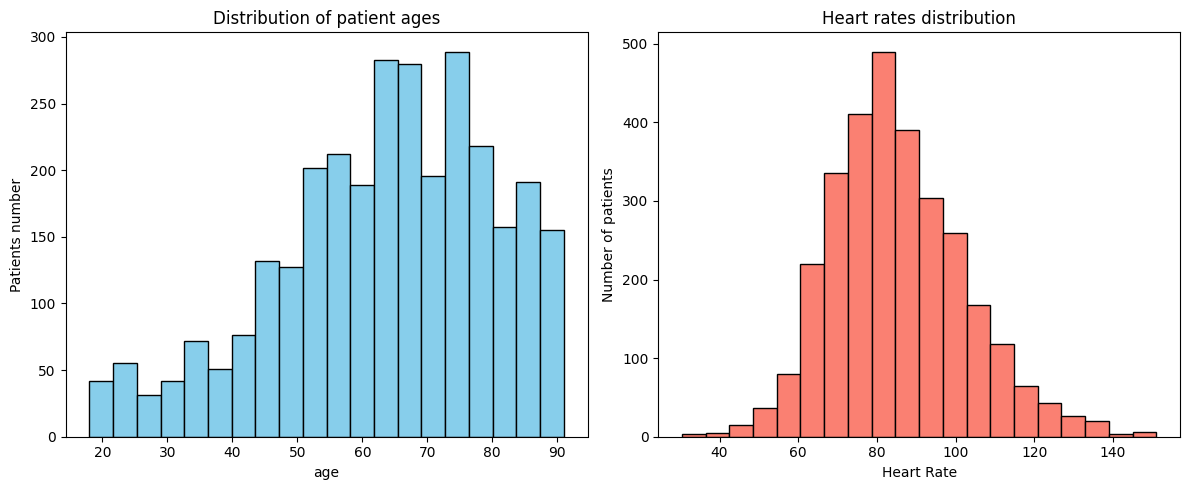

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('icu_data_example.csv')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['age'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('age')
plt.ylabel('Patients number')
plt.title('Distribution of patient ages')
plt.subplot(1, 2, 2)
plt.hist(df['Heart Rate'].dropna(), bins=20, color='salmon', edgecolor='black')
plt.xlabel('Heart Rate')
plt.ylabel('Number of patients')
plt.title('Heart rates distribution')
plt.tight_layout()
plt.show()

## Homework
### Homework Question 1

As a member of the data science team at Heilbronn Hospital, you need to develop a universal data cleaning tool to help different departments handle various types of medical data. Different medical indicators may have different missing data tolerance levels, and some indicators are suitable for mean imputation while others are better suited for median imputation. Your task is to design a flexible function to handle these different requirements. **Design a function called `smart_imputation` with the following capabilities**:

**Function Parameters**:
- `df`: Input DataFrame
- `column_name`: Name of the column to process (string)
- `threshold`: Missing data threshold percentage (float, e.g., 0.2 for 20%)
- `method`: Imputation method (string, 'mean' or 'median')

**Function Features**:
1. Check the missing data percentage of the specified column
2. If missing data percentage is below the given threshold, perform imputation using the specified method
3. If missing data percentage is above or equal to the threshold, do not perform imputation and print a warning message
4. Return the processed DataFrame and a dictionary containing processing information

**Return Values**:
- Processed DataFrame
- Information dictionary containing:
    - `column`: Name of the processed column
    - `missing_percentage`: Missing data percentage
    - `action_taken`: Action taken ('imputed' or 'no_action')
    - `method_used`: Method used (if imputation was performed)

**Example**
```python
result_df, info = smart_imputation(df, 'Heart_Rate', 0.15, 'median')
result_df, info = smart_imputation(df, 'Blood_Pressure', 0.25, 'mean')
```

In [9]:
def smart_imputation(df, column_name, threshold, method):
	info = {
		'column': column_name,
		'missing_percentage': None,
		'action_taken': 'no_action',
		'method_used': None
	}

	if column_name not in df.columns:
		raise ValueError(f"Column '{column_name}' not found in DataFrame.")

	missing_ratio = df[column_name].isnull().mean()
	info['missing_percentage'] = missing_ratio

	if missing_ratio < threshold:
		if method == 'mean':
			value = df[column_name].mean()
		elif method == 'median':
			value = df[column_name].median()
		else:
			raise ValueError("Method must be 'mean' or 'median'.")

		df.fillna(value, inplace=True)
		info['action_taken'] = 'imputed'
		info['method_used'] = method
	else:
		print(f"Skipped '{column_name}': Missing data {missing_ratio:.2%} exceeds threshold {threshold:.2%}")

	return df, info

### Homework Question 2

As a data analyst at Heilbronn Hospital's Quality Assurance Department, you've discovered that medical equipment occasionally produces anomalous measurements due to sensor malfunctions, patient movement during measurements, or data entry errors. The medical team needs a robust tool to automatically detect and handle these outliers in vital sign measurements. Different medical scenarios may require different outlier detection methods - some prefer the IQR method for its robustness, while others need the z-score method for normally distributed data. Your task is to create a flexible outlier detection and removal system. **Design a function called `outlier_detector` with the following capabilities**:

**Function Parameters**:
- `df`: Input DataFrame
- `column_name`: Name of the column to process (string)
- `method`: Outlier detection method (string, 'iqr' or 'zscore')
- `action`: What to do with outliers (string, 'remove', 'flag', or 'cap')
- `threshold`: Threshold parameter (float, default=1.5 for IQR, default=3.0 for z-score)

**Function Features**:
1. Detect outliers using the specified method (IQR or z-score)
2. Handle outliers based on the specified action:
    - 'remove': Remove outlier rows from DataFrame
    - 'flag': Add a boolean column indicating outliers
    - 'cap': Cap outliers to threshold boundaries
3. Provide detailed statistics about outliers detected
4. Return the processed DataFrame and comprehensive outlier information

**Return Values**:
- Processed DataFrame
- Information dictionary containing:
    - `column`: Name of the processed column
    - `method_used`: Detection method used
    - `action_taken`: Action performed on outliers
    - `outliers_detected`: Number of outliers found
    - `outliers_percentage`: Percentage of outliers
    - `outlier_indices`: List of outlier indices (if action != 'remove')
    - `bounds`: Upper and lower bounds used for detection
    - `original_shape`: Original DataFrame shape
    - `final_shape`: Final DataFrame shape

**Example**
```python
result_df, info = outlier_detector(df, 'Heart_Rate', 'iqr', 'remove', 1.5)
result_df, info = outlier_detector(df, 'Weight', 'zscore', 'flag', 3.0)
result_df, info = outlier_detector(df, 'Blood_Pressure', 'iqr', 'cap', 2.0)
```

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def outlier_detector(df, column_name, method='iqr', action='remove', threshold=None):
	if column_name not in df.columns:
		raise ValueError(f"Column '{column_name}' not found in DataFrame.")

	if method == 'iqr' and threshold is None:
		threshold = 1.5
	elif method == 'zscore' and threshold is None:
		threshold = 3.0    
	series = df[column_name]
	original_shape = df.shape

	if method == 'iqr':
		Q1 = series.quantile(0.25)
		Q3 = series.quantile(0.75)
		IQR = Q3 - Q1
		lower_bound = Q1 - threshold * IQR
		upper_bound = Q3 + threshold * IQR
		outlier_condition = (series < lower_bound) | (series > upper_bound)
	elif method == 'zscore':
		z_scores = zscore(series.dropna())
		outlier_indices_raw = np.abs(z_scores) > threshold
		outlier_condition = pd.Series(False, index=series.index)
		outlier_condition[series.dropna().index[outlier_indices_raw]] = True
		lower_bound = None
		upper_bound = None
	else:
		raise ValueError("Method must be 'iqr' or 'zscore'.")

	outlier_indices = df[outlier_condition].index.tolist()
	outliers_detected = len(outlier_indices)
	outliers_percentage = (outliers_detected / len(df)) * 100

	if action == 'remove':
		df = df[~outlier_condition].copy()
	elif action == 'flag':
		flag_col = f"{column_name}_outlier"
		df[flag_col] = outlier_condition
	elif action == 'cap':
		if method != 'iqr':
			raise ValueError("Capping is only supported with 'iqr' method.")
		df[column_name] = np.where(series > upper_bound, upper_bound,
		np.where(series < lower_bound, lower_bound, series))
	else:
		raise ValueError("Action must be 'remove', 'flag', or 'cap'.")

	info = {
		'column': column_name,
		'method_used': method,
		'action_taken': action,
		'outliers_detected': outliers_detected,
		'outliers_percentage': round(outliers_percentage, 2),
		'outlier_indices': outlier_indices if action != 'remove' else None,
		'bounds': (lower_bound, upper_bound),
		'original_shape': original_shape,
		'final_shape': df.shape
	}

	return df, info

### Homework Question 3
Advanced Visualization: Using Seaborn, create a box plot to visualize how patient age varies across different ICU stay duration categories. This visualization will help identify if certain age groups tend to require longer ICU stays, allowing for better prediction of resource needs.

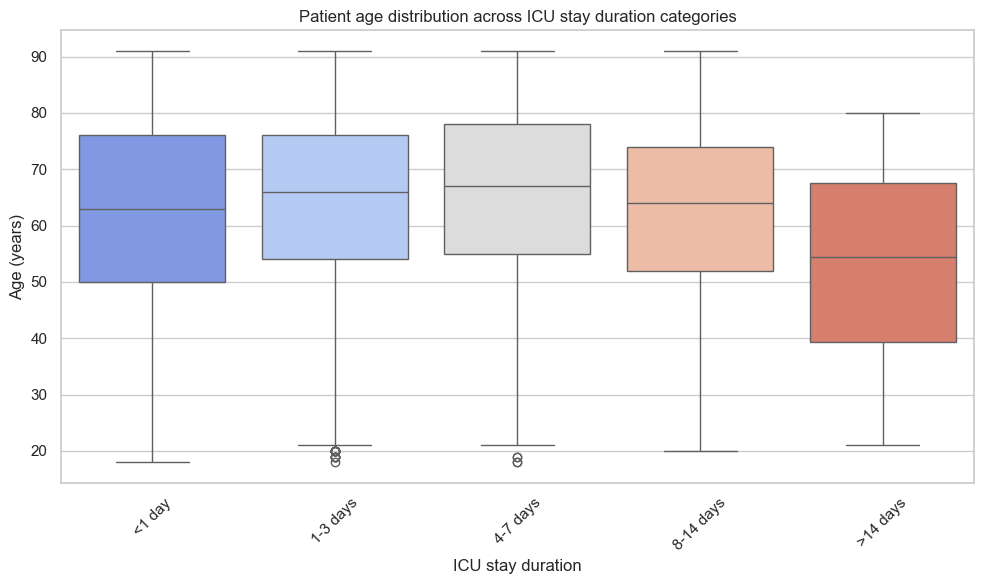

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('icu_data_example.csv')

df['los'] = pd.to_numeric(df['los'], errors='coerce')
df = df.dropna(subset=['los', 'age'])

stay_bins = [0, 1, 3, 7, 14, float('inf')]
stay_labels = ['<1 day', '1-3 days', '4-7 days', '8-14 days', '>14 days']
df['stay_category'] = pd.cut(df['los'], bins=stay_bins, labels=stay_labels)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='stay_category', y='age', hue='stay_category', data=df, palette="coolwarm", legend=False)

plt.title('Patient age distribution across ICU stay duration categories')
plt.xlabel('ICU stay duration')
plt.ylabel('Age (years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()